In [2]:
# default_exp data.external

In [3]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Data Collection

> Adding the M4 data to the fastai way of storing/downloading data.

Datasets to incl:

- [x] m4 daily
- [ ] gunpoint
- [ ] Phoneme <http://www.timeseriesclassification.com/description.php?Dataset=Phoneme>
- [ ] Worms <http://www.timeseriesclassification.com/description.php?Dataset=Worms>
- [ ] BeetleFly <http://www.timeseriesclassification.com/description.php?Dataset=BeetleFly>
- [ ] m4 hourly
- [ ] M5 

using zip files
https://forums.fast.ai/t/generalizing-untar-data-to-also-work-with-zips/53741/14?u=takotab

In [4]:
# export
from fastseq.core import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
import pandas as pd

## LstnetDatasets

In [5]:
base = "https://raw.githubusercontent.com/laiguokun/multivariate-time-series-data/master/"
URLs.exchange_rate = f'{base}exchange_rate/exchange_rate.txt.gz'
URLs.electricity = f"{base}electricity/electricity.txt.gz"
URLs.traffic = f"{base}traffic/traffic.txt.gz"

In [6]:
df = pd.read_csv(URLs.traffic, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,852,853,854,855,856,857,858,859,860,861
0,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,0.0518,...,0.0139,0.0179,0.0278,0.0280,0.0227,0.0375,0.0142,0.0201,0.0341,0.0429
17540,0.0285,0.0253,0.0542,0.0485,0.0131,0.0331,0.0372,0.0569,0.0669,0.0409,...,0.0116,0.0155,0.0201,0.0267,0.0207,0.0320,0.0122,0.0163,0.0306,0.0363
17541,0.0276,0.0257,0.0551,0.0474,0.0121,0.0326,0.0381,0.0566,0.0675,0.0386,...,0.0109,0.0142,0.0208,0.0252,0.0189,0.0287,0.0123,0.0152,0.0292,0.0325
17542,0.0232,0.0229,0.0496,0.0435,0.0119,0.0297,0.0361,0.0517,0.0598,0.0360,...,0.0092,0.0124,0.0219,0.0215,0.0169,0.0258,0.0096,0.0130,0.0252,0.0279


In [7]:
from typing import List, NamedTuple, Optional

def load_from_pandas(
    df: pd.DataFrame,
    time_index: pd.DatetimeIndex,
    agg_freq: Optional[str] = None,
) -> List[pd.Series]:
    df = df.set_index(time_index)

    pivot_df = df.transpose()
    pivot_df.head()

    timeseries = []
    for row in pivot_df.iterrows():
        ts = pd.Series(row[1].values, index=time_index)
        if agg_freq is not None:
            ts = ts.resample(agg_freq).sum()
        first_valid = ts[ts.notnull()].index[0]
        last_valid = ts[ts.notnull()].index[-1]
        ts = ts[first_valid:last_valid]

        timeseries.append(ts)

    return timeseries

In [8]:
timeseries = load_from_pandas(
    df=df, time_index=time_index, agg_freq=ds_info.agg_freq
)

NameError: name 'time_index' is not defined

In [9]:
from zipfile import ZipFile

url = "https://github.com/karoldvl/ESC-50/archive/master.zip"

def zip_extract(fname, dest):
    zipfile.ZipFile(fname, mode='r').extractall(dest)
    
fname = '/home/tako/.fastai/archive/traffic.txt.gz'
path = untar_data(URLs.traffic, extract_func=)


SyntaxError: invalid syntax (<ipython-input-9-3dda0cab2c99>, line 9)

In [10]:
path = untar_data(URLs.traffic)

ReadError: invalid header

In [ ]:
(path.parent / 'traffic').ls()

## M4 daily

In [11]:
# hide
URLs.IMAGEWOOF

'https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz'

In [12]:
# hide
path = untar_data(URLs.IMAGEWOOF)

In [13]:
# hide
path.ls()

(#2) [Path('/home/tako/.fastai/data/imagewoof2/val'),Path('/home/tako/.fastai/data/imagewoof2/train')]

In [14]:
# export
m4_base = "https://motionnet-m4-dataset.s3.eu-central-1.amazonaws.com/"
URLs.m4_daily = f'{m4_base}m4_daily.tgz'

In [15]:
URLs.m4_daily

'https://motionnet-m4-dataset.s3.eu-central-1.amazonaws.com/m4_daily.tgz'

In [16]:
# hide
try:
    os.remove(URLs.path(URLs.m4_daily))
except:
    pass
path = untar_data(URLs.m4_daily)

In [17]:
path = untar_data(URLs.m4_daily)
path.ls()

(#2) [Path('/home/tako/.fastai/data/m4_daily/train.csv'),Path('/home/tako/.fastai/data/m4_daily/val.csv')]

In [18]:
# export
def ts_lists(ts:np.ndarray, same_size = False)-> L:
    """Transforms a `np.ndarray` of shape (timeseries, max_time) to a list of timeseries with shape (1,time).
    """
    lst = L()
    for time_series in ts:
        l = slice(0,len(time_series)) if same_size else ~np.isnan(time_series)
        lst.append(time_series[l][None,:])
    return lst

In [19]:
o = np.array([[1,3,np.nan],
         [1,2,3],
         [1,np.nan,np.nan],
         ])
print(ts_lists(o))
print(ts_lists(o, True))

(#3) [array([[1., 3.]]),array([[1., 2., 3.]]),array([[1.]])]
(#3) [array([[ 1.,  3., nan]]),array([[1., 2., 3.]]),array([[ 1., nan, nan]])]


In [20]:
# export

m4_base = "https://motionnet-m4-dataset.s3.eu-central-1.amazonaws.com/"
URLs.m4_daily = f'{m4_base}m4_daily.tgz'

def get_m4_files(path):
    "Get times series from files in `path` recursively, only in `folders`, if specified."
    path = untar_data(URLs.m4_daily)
    train = pd.read_csv(path / 'train.csv', **kwargs).iloc[:, 1:].values
    valid = pd.read_csv(path / 'val.csv', **kwargs).iloc[:, 1:].values    
    return train, valid

In [21]:
x_train, x_valid = get_m4_files(path)

NameError: name 'kwargs' is not defined

In [ ]:
x_train.shape, x_valid.shape

In [22]:
# hide
test_eq(len(path.ls()),2)
path.ls()

(#2) [Path('/home/tako/.fastai/data/m4_daily/train.csv'),Path('/home/tako/.fastai/data/m4_daily/val.csv')]

## dummy

In [23]:
# export 
def dummy_data_generator(lookback:int, horizon:int, signal_type='seasonality', nrows:int=5, random = True, batch_size=32, norm=False, noise = .2):
    def get_datapoint():
        lin_space = np.linspace(-lookback, horizon, lookback + horizon)
        if random:
            offset = np.random.standard_normal() * .10
        else:
            offset = 1            
        if signal_type == 'lin':
            a =  np.random.standard_normal() * lin_space + offset * 100
        
        a = np.zeros_like(lin_space)            
        if signal_type is not 'seasonality':
            p = 4
            a = [(lin_space**(i))[None,:] for i in range(p)]
            T = np.concatenate(a)
            thetas = np.random.randn(4)*1*9**-p
            a= np.matmul(thetas,T) 
            
        if signal_type is not 'trend':
            a += np.cos(2 * np.random.randint(low=1, high=3) * np.pi * lin_space)* np.random.standard_normal() * .5
            a += np.cos(2 * np.random.randint(low=2, high=4) * np.pi * lin_space)* np.random.standard_normal() * .5
            a += np.sin(2 * np.random.randint(low=1, high=3) * np.pi * lin_space)
            a -= np.sin(2 * np.random.randint(low=2, high=4) * np.pi * lin_space)
            a += lin_space * offset + np.random.rand() * 10
            
        a += np.random.randn(a.shape[0])*noise
        if norm:
            return (a[None,:]-a.mean())/a.std()
        else:
            return a[None,:]
    
    data = L()
    for i in range(nrows):
        data.append(get_datapoint())        
        
    return data


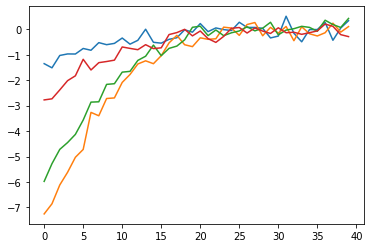

In [24]:
r = dummy_data_generator(30,10,signal_type='trend')
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

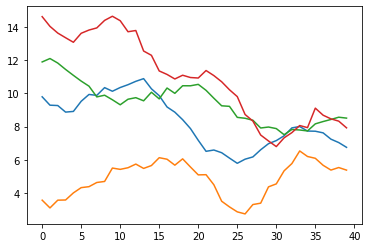

In [25]:
r = dummy_data_generator(30,10)
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

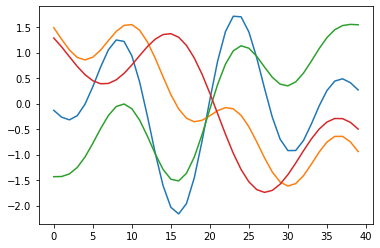

In [26]:
r = dummy_data_generator(30,10,norm=True, noise = 0)
plt.plot(r[0][0,:])
plt.plot(r[1][0,:])
plt.plot(r[2][0,:])
plt.plot(r[3][0,:])

# Multivariate

## easy

In [27]:
# export
def dummy_generator_multi_easy(length, signal_type='none',nrows:int=5, random = True, noise = .3,
                               norm = True, norm_t = True, increase_noise = False, rang = [5,5]):

    data = L() 
    for i in range(nrows):
        weather = dummy_data_generator(length-10, 10, signal_type = 'seasonality', nrows=1, random=random, noise = 0 )[0]
        n = (1+np.random.randn(length) * np.arange(0,10*length, 10) * .001 * noise)[None,:]
        final = (rang[0] + np.random.sample()*(rang[1]-rang[0])) * weather * n
        if norm:
            final = (final-final.mean())/final.std()
        if norm_t:
            weather = (weather-weather.mean())/weather.std()            
        tot = {'x':final,'weather': weather}
        data.append(tot)           
        
    return pd.DataFrame(data)

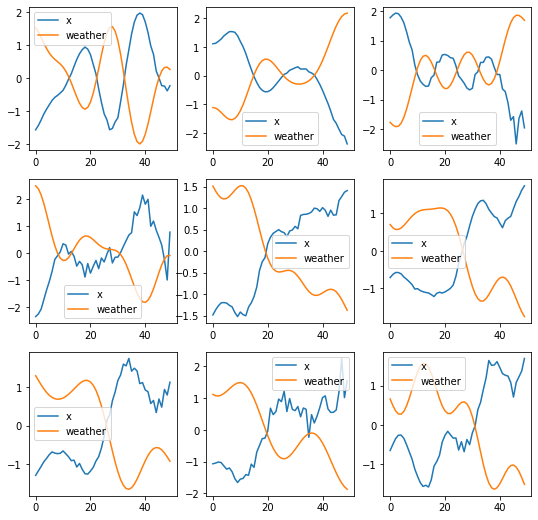

In [28]:
from fastai2.vision.data import get_grid
df = dummy_generator_multi_easy(50,nrows=9, noise = .1, rang=[-1,0])

ctxs = get_grid(len(df))
for i, ctx in enumerate(ctxs):
    for k in ['x', 'weather', 'n']:
        if k in df:      
            ctx.plot(df[k][i][0,:], label= k)
    ctx.legend()

## Hard

In [29]:
# export 

def dummy_data_generator_multi(length, citys=2, cont = False, signal_type='none',nrows:int=5, random = True, noise = .2, incl_city_trend = False, norm= True, increase_noise = False):
    city_names=['adam','rdam','zdam','istanbul','berlin','barcalona','NYC','LA']
    data = L()
    for city_i in range(citys):
        city_trend = dummy_data_generator(length//2, length//2, signal_type = 'trend', nrows=1, random=random, noise = 0 )[0]  
        for i in range(nrows):
            if noise > .15:
                weather = dummy_data_generator(length//2, 0, signal_type = 'seasonality', nrows=1, random=random, noise = 0 )[0]
                weather = np.concatenate([weather,weather],-1)
            else:
                weather = dummy_data_generator(length-10, 10, signal_type = 'seasonality', nrows=1, random=random, noise = 0 )[0]
                
            cont = np.random.randn()
            if cont: 
                city_weather = cont * city_trend + weather
            else:
                city_weather = city_trend + weather
            normal_signal = 3 * dummy_data_generator(length//2, length//2, signal_type = signal_type, nrows=1, random=random, noise = noise )[0]                 
            if increase_noise:
                city_weather += dummy_data_generator(2, length-2, signal_type = 'seasonality', nrows=1, random=random, noise = noise,norm=True )[0] * (np.random.randn(length) *(np.arange(length) * (1/length) ) * noise)
            final = normal_signal + city_weather * (1+np.random.randn(length) * .1 * noise)
            if norm:
                final = (final-final.mean())/final.std()
            tot = {'x': final,'weather': weather,'city': city_names[city_i]}
            if incl_city_trend:
                tot['city_trend']=city_trend
            if cont:
                tot['cont'] = cont
            data.append(tot)           
        
    return pd.DataFrame(data)

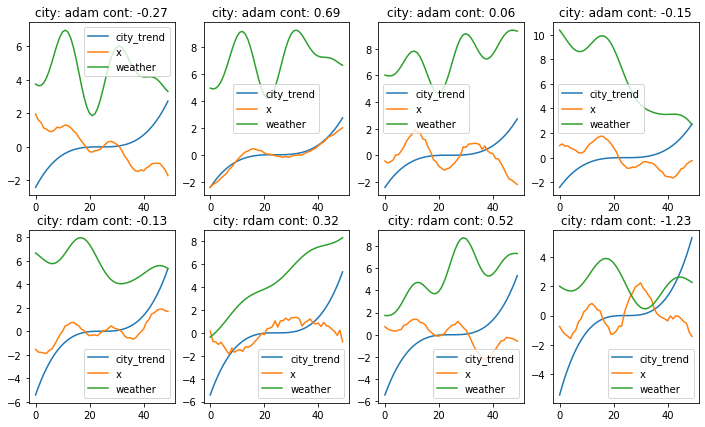

In [30]:
from fastai2.vision.data import get_grid
df = dummy_data_generator_multi(50, nrows = 4, noise = .1, incl_city_trend = True, cont = True)

ctxs = get_grid(len(df), rows=2, cols=4, add_vert=1)
for i, ctx in enumerate(ctxs):
    for k in ['city_trend', 'x', 'weather']:
        if k in df:      
            ctx.plot(df[k][i][0,:], label= k)
    ctx.set_title(f"city: {str(df['city'][i])} cont: {str(np.round(df['cont'][i],2))}")
    ctx.legend()

## Data saving and restoring from json

In [31]:
# export
import numpy as np
import pandas as pd
import orjson

In [32]:
# export
class TSMulti(MultiTuple):pass

In [33]:
# export
def get_df(length = [100,120], use_str = True, classes = {}):
    dct = {'x':[],'con_ts_1':[],'con_ts_0':[],'cat_ts_1':[],'cat_ts_0':[],'con_0':[],'con_1':[], 'cat_0':[],'cat_1':[]}
    for i, l in enumerate(length):
#         assert int(l/2) == l/2
        dct['x'].append(np.arange(l))
        dct['con_ts_0'].append(np.arange(l)[None,:])
        dct['con_ts_1'].append(pd.Series(np.arange(l)+np.random.randn(l)))
        dct['con_0'].append(np.random.rand()*2-1)
        dct['con_1'].append(10+np.random.rand()*2)       
        if 'cat_ts_0' in classes:
            lst = classes['cat_ts_0']
        else:
            lst = ['a','b'] if use_str else [0,1]
        dct['cat_ts_0'].append([random.choice(lst) for _ in range(l)])  
        if 'cat_ts_1' in classes:
            lst = classes['cat_ts_1']
        else:            
            lst = ['david','john'] if use_str else [0,1]
        dct['cat_ts_1'].append([random.choice(lst) for _ in range(l)])  
        if 'cat_0' in classes:
            lst = classes['cat_0']
        else:            
            lst = ['a','b'] if use_str else [0,1]
        dct['cat_0'].append(random.choice(lst))  
        if 'cat_1' in classes:
            lst = classes['cat_1']
        else:                   
            lst = ['adam','rdam'] if use_str else [0,1]
        dct['cat_1'].append(random.choice(lst))  
    return pd.DataFrame(data=dct)   

In [34]:
# hide 
df = get_df([10,12,6], False)
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 0.309139 1 0.047026 2 1.522486 3 3.433259 4 3.035702 5 4.978890 6 6.834358 7 7.380542 8 8.812466 9 9.027737 dtype: float64,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[1, 1, 1, 1, 0, 0, 1, 1, 1, 1]","[1, 1, 0, 1, 1, 0, 0, 1, 1, 1]",-0.275049,11.012413,0,0
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0 -0.435180 1 1.237169 2 1.621297 3 1.822971 4 4.534944 5 5.216003 6 9.142358 7 7.649839 8 7.565236 9 7.880724 10 8.835421 11 10.640338 dtype: float64,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]","[0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]","[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]",0.130315,11.675666,0,0
2,"[0, 1, 2, 3, 4, 5]",0 -1.454328 1 1.082003 2 1.912846 3 2.664603 4 3.981577 5 5.240766 dtype: float64,"[[0, 1, 2, 3, 4, 5]]","[0, 1, 0, 1, 1, 0]","[0, 0, 0, 1, 1, 1]",0.561754,11.237534,1,1


In [35]:
df = get_df([10,12,6])
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 0.611450 1 0.824208 2 1.556349 3 4.633472 4 4.428412 5 3.381130 6 5.279722 7 7.044104 8 9.476132 9 10.612472 dtype: float64,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[david, david, david, david, john, david, david, david, john, david]","[b, a, b, b, a, a, b, a, b, b]",-0.869162,11.374391,b,adam
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0 1.262760 1 1.188884 2 3.027138 3 3.080977 4 3.594078 5 4.138080 6 6.184328 7 6.790515 8 6.495304 9 7.990631 10 9.740386 11 10.234208 dtype: float64,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]","[david, john, david, david, john, john, david, david, david, john, john, john]","[b, a, b, a, b, a, a, a, a, b, b, b]",-0.353029,10.461238,a,rdam
2,"[0, 1, 2, 3, 4, 5]",0 2.053636 1 1.150805 2 2.750201 3 3.131718 4 4.634671 5 5.610231 dtype: float64,"[[0, 1, 2, 3, 4, 5]]","[david, john, john, john, john, john]","[a, b, b, b, b, a]",0.344362,10.791053,a,adam


In [36]:
df = get_df([5,3,5],classes={'cat_0':['a','b','c'],
                               'cat_ts_1':['john','david','johan','denis'],
                              'cat_ts_0':['ab','bb','ba','c','dd']})
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4]",0 -0.412194 1 -3.097148 2 2.404612 3 2.659257 4 4.754342 dtype: float64,"[[0, 1, 2, 3, 4]]","[john, johan, david, david, david]","[c, dd, bb, c, c]",-0.071235,10.409056,b,rdam
1,"[0, 1, 2]",0 -0.503307 1 1.331157 2 1.914578 dtype: float64,"[[0, 1, 2]]","[johan, denis, johan]","[dd, ab, c]",0.423380,11.755280,c,adam
2,"[0, 1, 2, 3, 4]",0 -1.197982 1 0.966530 2 3.897946 3 3.535701 4 3.513378 dtype: float64,"[[0, 1, 2, 3, 4]]","[john, denis, denis, david, johan]","[dd, ba, ab, c, ab]",-0.944959,10.959907,c,adam


In [37]:
# export
def add_dct(dct, k, o):
    if type(o) == set:
        o = list(o)
        
    if type(o) == list or type(o) == L:
        if k in dct:
            dct[k] = list(set(dct[k] +o))
        else:
            dct[k] = o
    elif type(o) == dict or type(o) == collections.defaultdict:
        if k not in dct:
            dct[k] = {}            
        for _k,v in o.items():
            dct[k] = add_dct(dct[k], _k, v)
    elif type(o) == int or type(o) == float:
        dct[k] = o
    else:
        raise Exception(type(o))
    return dct

In [38]:
dct={'foo':'bar'}
dct = add_dct(dct, 'foo2',['bar2'])
test_eq(len(dct), 2)
dct = add_dct(dct, 'foodct',dict(a=1))
test_eq(dct['foodct'] , dict(a=1))
o = defaultdict(list)
o[1].append(0)
dct = add_dct(dct,'defaultdict',o )
test_eq(dct['defaultdict'][1],[0])

dct = add_dct(dct,'set',set([1,2,2]) )
test_eq(dct['set'],[1,2])

dct = add_dct(dct,'set2',{'set':set([1,2,2])} )
test_eq(dct['set2']['set'],[1,2])

In [39]:
# export
import json
def _save_dct(f,dct):
    json.dump(dct, open(f,'w'), indent = 2, sort_keys = True)               
    return f

def make_meta_file(path, **kwargs):
    dct = {}
    f = path / '.ts_meta'
    if (path / '.ts_meta').exists():
        dct = json.load(open(f))
    for k,v in kwargs.items():
        dct = add_dct(dct,k,v)
    return _save_dct(f,dct)

In [40]:
p = Path('../data/test_data')
p.delete();p.mkdir()
f = make_meta_file(p, **dict(a=1))
test_eq(f.exists(),True)
test_eq(json.load(open(f)),dict(a=1))

In [48]:
# export
class Meta(dict):pass

class TS(dict):
    @classmethod
    def load(cls, f):
        return cls(orjson.loads(open(f,'rb').read()))

    def get_ts(self, meta:Meta, key):
        """Ensures it is always same order"""
        try:
            return [self[key][o] for o in meta['col_names'][key+'_names']]
        except KeyError:
            assert key in ['cat','con','ts_cat','ts_con']

    def get_np(self,meta:Meta, key):return np.array(self.get_ts(meta,key))
    def __len__(self):return self['_length']

    def __str__(self):
        s = ''
        for k,v in self.items():
            if type(v) == dict:
                o={col: L(o) for col,o in v.items()}
                s += f"{k}:{o} \n"
            else:
                s += f"{k}:{v}"
        return s
    
def get_ts_datapoint(f) -> TS:
    return TS(orjson.loads(open(f,'rb').read()))

def get_meta(path:Path):
    f = path / '.ts_meta'
    return Meta(json.load(open(f,'r')))        

In [50]:
path = Path('../data/test_data')
path.delete()
path.mkdir()
_save_dct(path / '1.json',
    {'cat':{'cat_0':'b','cat_1':'rdam'}, 'con':{'con_0':10,'con_1':0}, 
     'ts_con': {k:[np.random.randn() for _ in range(80)] for k in ['con_ts_1','con_ts_0','x']},
     'ts_cat': {k:['a' for _ in range(80)] for k in ['cat_ts_0','cat_ts_1']},
    '_length':80
            })

make_meta_file(path,
        **{"col_names": {
        "cat_names": ["cat_0", "cat_1"],
        "con_names": ["con_1", "con_0"],
        "ts_cat_names": ["cat_ts_1", "cat_ts_0"],
        "ts_con_names": ["x", "con_ts_1", "con_ts_0"],
        }})

ts = TS.load(path / '1.json')
test_eq(set(ts.get_ts(get_meta(path), 'cat')),set(['rdam','b']))
test_close(ts.get_ts(get_meta(path), 'con'),[0,10], 2)
test_close(ts.get_np(get_meta(path), 'ts_con').shape,(3, len(ts)))
test_close(ts.get_np(get_meta(path), 'ts_cat').shape,(2, len(ts)))
print(ts)

_length:80cat:{'cat_0': (#1) ['b'], 'cat_1': (#1) ['rdam']} 
con:{'con_0': (#1) [10], 'con_1': (#1) [0]} 
ts_cat:{'cat_ts_0': (#80) ['a','a','a','a','a','a','a','a','a','a'...], 'cat_ts_1': (#80) ['a','a','a','a','a','a','a','a','a','a'...]} 
ts_con:{'con_ts_0': (#80) [0.7321586399361827,-0.5214408748904866,1.1812388903882116,-1.9774562179443915,-0.9245256302606167,0.6323080060934176,0.3216575032661945,-0.7482416448496355,0.7442033759864223,-0.6291249324496511...], 'con_ts_1': (#80) [-2.1866951252496074,-0.10604675089993344,-1.115976692277744,-1.1273886000492743,0.031217403255163152,0.3223875754674972,0.5302546566925511,1.2489988766102724,-0.3318078381445021,-1.5500795460112073...], 'x': (#80) [-0.33917111821443097,0.4913267393977968,-2.552627710392637,0.5563070426248893,-0.9112620152787928,-1.5206770810499417,-0.30699906962897705,-0.16531751534498004,0.38883290843367196,0.15453430934322815...]} 



In [187]:
# export
def python_type(o):
    if isinstance(o,int) or type(o) == np.int64:
        return int(o)
    elif isinstance(o,float) or type(o) == np.float64:
        if int(o) == o:
            return int(o)
        return float(o)
    elif type(o) == str:
        return o
    elif type(o) == pd.Series:
        return [python_type(v) for k,v in dict(o).items()]
    elif isinstance(o,list) or isinstance(o,L):
        return [python_type(v) for v in o]
    elif isinstance(o,np.ndarray):
        return [python_type(v) for v in list(o.flatten())]
    raise Exception(f"{type(o)}, {o}")
    

In [188]:
test_eq(python_type(np.array([0,0])),[0,0])
test_eq(type(python_type(np.array([1.,0.]))[0]),int)
test_eq(python_type(pd.Series(np.arange(10))),list(np.arange(10)))
test_eq(python_type(np.arange(10)[None,:]),list(np.arange(10)))

In [189]:
# export
def _check_length(lst, length):    
    if length is None:
        length = len(lst)
    else:
        assert len(lst) == length
    return length

def _from_dict_to_defaultdict(dct, default):
    _dct = dct
    dct = defaultdict(default)
    for k,v in _dct.items():
        dct[k] = v
    return dct

def reconize_cols(datapoint:dict, con_names=None, cat_names=None, ts_con_names=None,
                  ts_cat_names=None, classes = {}):
    """Gets the con_names, cat_names, ts_con_names, ts_cat_names for the `datapoint`"""
    con_names, cat_names, ts_con_names, ts_cat_names = [ifnone(o, []) for o in [con_names, cat_names, ts_con_names, ts_cat_names]]
    length = None    
    classes = _from_dict_to_defaultdict(classes, set)
    for k,v in datapoint.items():
        if k in con_names+cat_names+ ts_con_names+ts_cat_names:
            if k in cat_names+ts_cat_names:
                if k not in classes:
                    for _v in set(v):
                        classes[k].add(_v)                 
            if k in ts_cat_names + ts_con_names:
                length = _check_length(v, length)                
        elif type(v) == int or isinstance(v,float):
            con_names.append(k)
        elif type(v) == str:
            cat_names.append(k)
            classes[k].add(v)
        elif isinstance(v,list) and (type(v[0]) == int or type(v[0]) == float):
            ts_con_names.append(k)
            length = _check_length(v, length)
        elif isinstance(v, list) and (type(v[0]) == str):
            ts_cat_names.append(k)
            length = _check_length(v, length)
            for _v in set(v):
                classes[k].add(_v)
        else:
            raise TypeError(type(v), type(v[0]))
            
    col_names = {k:list(set(v)) for k,v in zip('con_names, cat_names, ts_con_names, ts_cat_names'.split(', '),
                                         [con_names, cat_names, ts_con_names, ts_cat_names],)}
    names = [list(o) for o in [con_names, cat_names, ts_con_names, ts_cat_names]]
    return length, classes, col_names, names

In [190]:
length, classes, col_names, names = reconize_cols({'_ts_cat':['a','b','a'],
                                                  '_ts_con':[0,0,1],
                                                  '_cat':'z',
                                                  '_con':.3})
test_eq(length,3)
test_eq(names, [['_con'], ['_cat'], ['_ts_con'], ['_ts_cat']])
test_eq(dict(classes), {'_ts_cat':{'a','b'},'_cat':{'z'}})

In [191]:
length, classes, col_names, names = reconize_cols({'_ts_cat':['a','b','a'],
                                                  '_ts_con':[0,0,1],
                                                  '_cat':['a','z','a'],
                                                  '_con':.3},[])
test_eq(length,3)
test_eq(names, [['_con'], [], ['_ts_con'], ['_ts_cat', '_cat']])
test_eq(dict(classes), {'_ts_cat':{'a','b'},'_cat':{'a','z','a'}})

In [192]:
# export
def make_compact(dp, con_names, cat_names, ts_con_names, ts_cat_names, **kwargs):
    r = {'_'+k:v for k,v in kwargs.items()}  
    r['con'] = {k:dp[k] for k in con_names}
    r['cat'] = {k:dp[k] for k in cat_names}
    r['ts_con'] = {k:[float(i) for i in dp[k]] for k in ts_con_names}
    r['ts_cat'] = {k:dp[k] for k in ts_cat_names}
    return r        

@delegates(reconize_cols)
def save_row(row, path:Path, fname='1', **kwargs):
    if not path.exists(): path.mkdir()
    if fname[-5:] is not '.json': fname += '.json'
    o = {k:python_type(v) for k,v in dict(row).items()}   
    length, classes, col_names, names = reconize_cols(o, **kwargs)
    o = make_compact(o, *names, length = length)
    make_meta_file(path, classes=classes, col_names = col_names)
    open(path / fname,'wb').write(orjson.dumps(o, ))
    return path / fname

In [193]:
df = get_df([6])
path = Path('../data/test_data')
path.delete();path.mkdir()
f = save_row(df.iloc[0,:], path)
dct = orjson.loads(open(f,'rb').read())
test_eq(dct['_length'],6)
test_eq(get_meta(path)['classes']['cat_ts_1'],['david','john'])

In [194]:
# export
@delegates(save_row)
def save_df(df:pd.DataFrame, path:Path, **kwargs):
    for i, row in df.iterrows():
        save_row(row, path, fname=str(i), **kwargs)

In [214]:
# export
def del_create(length = [80, 80, 80], path = Path('../data/test_data'), use_str = True, classes =None):
    if classes is None:
        classes = dict(cat_ts_0=['a','b'], cat_ts_1=['david','john'],
                        cat_0 = ['a','b'], cat_1= ['adam','rdam'])
    
    df = get_df(length, use_str, classes = (classes if use_str else {}))
    if path.exists(): path.delete()
    path.mkdir()
    save_df(df, path, ts_cat_names = [o for o in list(df.columns) if o in ['cat_ts_0', 'cat_ts_1'] ],
           cat_names = ['cat_0','cat_1'], classes=classes)
    return [path / (str(i) + '.json') for i in range(0,3)]

In [215]:
del_create([10,10,10])

[Path('../data/test_data/0.json'),
 Path('../data/test_data/1.json'),
 Path('../data/test_data/2.json')]

In [216]:
# hide
del_create([10,10,10], use_str = False)

[Path('../data/test_data/0.json'),
 Path('../data/test_data/1.json'),
 Path('../data/test_data/2.json')]

In [207]:
r = del_create(use_str = False)
meta=get_meta(r[0].parent)
test_eq(set(meta['col_names']['ts_cat_names']),set(['cat_ts_1', 'cat_ts_0',]))
test_eq(set(meta['col_names']['ts_con_names']),set(['con_ts_1', 'con_ts_0','x']))
test_eq(set(meta['classes']['cat_1']),{'adam', 'rdam'})

In [208]:
# export 
def meta_from_path(path:Path):
    for f in path.glob('*.json'):
        ts = get_ts_datapoint(f)
        o ={}
        for typ in ['cat','ts_cat','ts_con','con']:
            o.update({k:python_type(v) for k,v in ts[typ].items()})
        length, classes, col_names, names = reconize_cols(o)
        o = make_compact(o, *names, length = length)
        r = make_meta_file(path, classes=classes, col_names = col_names)
    return r

In [209]:
path = Path('../data/test_data')
path.delete()
path.mkdir()
_save_dct(path / '1.json',
    {'cat':{'cat_0':'b','cat_1':'rdam'}, 'con':{'con_0':10,'con_1':0}, 
     'ts_con': {k:[np.random.randn() for _ in range(80)] for k in ['con_ts_1','con_ts_0','x']},
     'ts_cat': {k:['a' for _ in range(80)] for k in ['cat_ts_0','cat_ts_1']},
    '_length':80
            })
f = meta_from_path(path)
json.load(open(f))

{'classes': {'cat_0': ['b'],
  'cat_1': ['rdam'],
  'cat_ts_0': ['a'],
  'cat_ts_1': ['a']},
 'col_names': {'cat_names': ['cat_0', 'cat_1'],
  'con_names': ['con_1', 'con_0'],
  'ts_cat_names': ['cat_ts_1', 'cat_ts_0'],
  'ts_con_names': ['con_ts_0', 'x', 'con_ts_1']}}

In [234]:
path = del_create([50,50], use_str = False)
meta = path[0].parent / '.ts_meta'
os.remove(meta)
f = meta_from_path(path[0].parent)
json.load(open(f))['col_names']

{'cat_names': [],
 'con_names': ['con_1', 'cat_0', 'con_0', 'cat_1'],
 'ts_cat_names': [],
 'ts_con_names': ['con_ts_1', 'cat_ts_1', 'x', 'con_ts_0', 'cat_ts_0']}

In [261]:
# export
def _get_classes(self):
    r = {}
    for k,names in self['col_names'].items():
        for col in names:
            if col in self['classes']:
                r[col] = self['classes'][col]
    return r
Meta.get_classes = _get_classes


In [262]:
path = Path('../data/test_data')
del_create([8,8,8],path = path)
meta = get_meta(path)
test_eq(meta.get_classes().keys(), [*meta['col_names']['cat_names'],*meta['col_names']['ts_cat_names']])

In [289]:
# export
def _del_col(self, del_col):
    r = {}
    for names,v in self['col_names'].items():
        r[names] = []
        for col in v:
            if del_col != col:
                r[names].append(col)
    self['col_names'] = r
    return self
Meta.del_col = _del_col

In [291]:
path = Path('../data/test_data')
del_create([8,8,8],path = path)
meta = get_meta(path)

test_eq(meta.del_col('cat_1')['col_names']['cat_names'], ['cat_0'])
test_eq(meta.del_col('cat_ts_1')['col_names']['ts_cat_names'], ['cat_ts_0'])
test_eq(meta.get_classes().keys(),['cat_0','cat_ts_0'])

In [51]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 00_m5.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.procs.ipynb.
Converted 05_data.m5.ipynb.
Converted 10_model.base.ipynb.
Converted 11_metrics.ipynb.
Converted 11_model.conv.ipynb.
Converted 12_compare.ipynb.
Converted 12_model.rnn.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.
Converted test.ipynb.


In [241]:
x = torch.randn(64,1,2*28)
def lagging(x, shift = 7, fill = 0):
    o = x[:,:,shift:]
    return torch.cat([torch.ones_like(x)[:,:,:shift]*fill, o],-1 )
lagging(x).shape

torch.Size([64, 1, 56])